In [4]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  
sns.set(style="darkgrid")  

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from keras import metrics

## Initial model workspace

In [2]:
# Read data
df = pd.read_csv('/Users/achen1/MIDS-W207-DeforestationAndClimate/data/train_monthly.csv', sep='\t')
print(df)

     Unnamed: 0     date  cdsd  cldd  dp01  dp10  dp1x  dsnd  dsnw  dt00  ...  \
0             0  2001-01   0.0   0.0  10.0   5.0   0.0  28.0   6.0   0.0  ...   
1             1  2001-02   0.0   0.0  13.0  10.0   1.0  28.0  10.0   0.0  ...   
2             2  2001-03   0.0   0.0   7.0   6.0   0.0  21.0   3.0   0.0  ...   
3             3  2001-04   0.0   0.0   8.0   6.0   0.0  12.0   6.0   0.0  ...   
4             4  2001-05   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0  ...   
..          ...      ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
162         162  2014-08  45.8   5.3   5.0   2.0   0.0   0.0   0.0   0.0  ...   
163         163  2014-09  46.7   0.9   4.0   2.0   0.0   0.0   0.0   0.0  ...   
164         164  2014-10  46.7   0.0   4.0   2.0   0.0   0.0   0.0   0.0  ...   
165         165  2014-11  46.7   0.0   9.0   6.0   1.0   1.0   1.0   0.0  ...   
166         166  2014-12  46.7   0.0  10.0   9.0   1.0  14.0   4.0   0.0  ...   

     tc_loss_ha_Uruguay  tc

In [3]:
# Check for NaN
nan_counts = df.isna().sum(axis=1)
print(nan_counts)

# Columns with NaN
all_nan_columns = df.columns[df.isna().all()]
print(all_nan_columns)

0      6
1      6
2      6
3      6
4      6
      ..
162    6
163    6
164    6
165    6
166    6
Length: 167, dtype: int64
Index(['dyfg', 'dyts'], dtype='object')


In [4]:
print(df[[col for col in df.columns if 'average' in col]])

     carbon_average  tc_loss_ha_average
0      2.056476e+07        56587.483051
1      2.056476e+07        56587.483051
2      2.056476e+07        56587.483051
3      2.056476e+07        56587.483051
4      2.056476e+07        56587.483051
..              ...                 ...
162    4.359131e+07       100562.338983
163    4.359131e+07       100562.338983
164    4.359131e+07       100562.338983
165    4.359131e+07       100562.338983
166    4.359131e+07       100562.338983

[167 rows x 2 columns]


In [5]:
df.head()

,Unnamed: 0,date,cdsd,cldd,dp01,dp10,dp1x,dsnd,dsnw,dt00,...,tc_loss_ha_Uruguay,tc_loss_ha_Uzbekistan,tc_loss_ha_Vanuatu,tc_loss_ha_Venezuela,tc_loss_ha_Vietnam,"tc_loss_ha_Virgin Islands, U.S.",tc_loss_ha_Zambia,tc_loss_ha_Zimbabwe,tc_loss_ha_Åland,tc_loss_ha_average
0,0,2001-01,0.0,0.0,10.0,5.0,0.0,28.0,6.0,0.0,...,7647,295,124,123881,47433,123,30124,8206,397,56587.483051
1,1,2001-02,0.0,0.0,13.0,10.0,1.0,28.0,10.0,0.0,...,7647,295,124,123881,47433,123,30124,8206,397,56587.483051
2,2,2001-03,0.0,0.0,7.0,6.0,0.0,21.0,3.0,0.0,...,7647,295,124,123881,47433,123,30124,8206,397,56587.483051
3,3,2001-04,0.0,0.0,8.0,6.0,0.0,12.0,6.0,0.0,...,7647,295,124,123881,47433,123,30124,8206,397,56587.483051
4,4,2001-05,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,7647,295,124,123881,47433,123,30124,8206,397,56587.483051


In [14]:
# Feature selection
tf.random.set_seed(1234)
np.random.seed(1234)


print(df.loc[:,['date','snow','carbon_average','tc_loss_ha_average']][:5])

df = df[['date','snow','carbon_average','tc_loss_ha_average']]
print(df.head())


      date    snow  carbon_average  tc_loss_ha_average
0  2001-01   661.0    2.056476e+07        56587.483051
1  2001-02  1589.0    2.056476e+07        56587.483051
2  2001-03   178.0    2.056476e+07        56587.483051
3  2001-04   580.0    2.056476e+07        56587.483051
4  2001-05     0.0    2.056476e+07        56587.483051
              snow  carbon_average  tc_loss_ha_average
date                                                  
2001-01-01   661.0    2.056476e+07        56587.483051
2001-02-01  1589.0    2.056476e+07        56587.483051
2001-03-01   178.0    2.056476e+07        56587.483051
2001-04-01   580.0    2.056476e+07        56587.483051
2001-05-01     0.0    2.056476e+07        56587.483051


In [15]:
# Additional imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

tf.random.set_seed(1234)
np.random.seed(1234)



In [16]:
# Partition date values
tf.random.set_seed(1234)
np.random.seed(1234)

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Split into feature and outcome sets
X = df[['year', 'month', 'carbon_average', 'tc_loss_ha_average']]
y = df['snow']


In [17]:
# Train test split
tf.random.set_seed(1234)
np.random.seed(1234)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


In [20]:
# Run simple model and measure MSE
tf.random.set_seed(1234)
np.random.seed(1234)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)



Mean Squared Error: 348138.3478853962


In [21]:
# Simple model measuring R squared
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, y_pred)
print('R-squared:', r_squared)

R-squared: 0.0547199334136127


# Remodel
## Base

In [70]:
# Additional imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [39]:
# Read data
df = pd.read_csv('/Users/achen1/MIDS-W207-DeforestationAndClimate/data/train_monthly.csv', sep='\t')
print(df.columns)

Index(['Unnamed: 0', 'date', 'cdsd', 'cldd', 'dp01', 'dp10', 'dp1x', 'dsnd',
       'dsnw', 'dt00',
       ...
       'tc_loss_ha_Uruguay', 'tc_loss_ha_Uzbekistan', 'tc_loss_ha_Vanuatu',
       'tc_loss_ha_Venezuela', 'tc_loss_ha_Vietnam',
       'tc_loss_ha_Virgin Islands, U.S.', 'tc_loss_ha_Zambia',
       'tc_loss_ha_Zimbabwe', 'tc_loss_ha_Åland', 'tc_loss_ha_average'],
      dtype='object', length=1135)


In [40]:
# Test base model within data set

# "DP10" = Number of days with >= 0.1 inch/2.54 millimeters in the year.
# "EMXP" = Highest daily total of precipitation in the year.
# "SNOW" = Total Annual Snowfall. 
# "PRCP" = Total Annual Precipitation.

# tf.random.set_seed(1234)
# np.random.seed(1234)

print(df[['date','dp10','emxp','snow','prcp']].head(10))

df_base = df[['date','dp10','emxp','snow','prcp']]
print(df_base)


      date  dp10  emxp    snow   prcp
0  2001-01   5.0  18.3   661.0   47.9
1  2001-02  10.0  27.9  1589.0  123.5
2  2001-03   6.0  13.5   178.0   39.8
3  2001-04   6.0  19.6   580.0   58.9
4  2001-05   1.0   6.1     0.0    6.1
5  2001-06   0.0   0.0     0.0    0.0
6  2001-07   0.0   0.0     0.0    0.0
7  2001-08   0.0   0.0     0.0    0.0
8  2001-09   1.0   8.9     0.0    8.9
9  2001-10   1.0  20.3     0.0   21.6
        date  dp10  emxp    snow   prcp
0    2001-01   5.0  18.3   661.0   47.9
1    2001-02  10.0  27.9  1589.0  123.5
2    2001-03   6.0  13.5   178.0   39.8
3    2001-04   6.0  19.6   580.0   58.9
4    2001-05   1.0   6.1     0.0    6.1
..       ...   ...   ...     ...    ...
162  2014-08   2.0  13.5     0.0   22.8
163  2014-09   2.0  17.8     0.0   24.4
164  2014-10   2.0  10.9     0.0   17.3
165  2014-11   6.0  25.7    64.0   59.7
166  2014-12   9.0  40.9   165.0  116.2

[167 rows x 5 columns]


In [71]:
# Create feature and outcome

tf.random.set_seed(1234)
np.random.seed(1234)

X = df_base[['dp10', 'emxp', 'prcp']]  # Features
y = df_base['snow']  # Target variable

# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


In [59]:
# Simple model

tf.random.set_seed(1234)
np.random.seed(1234)

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [60]:
# Simple model measuring MSE

tf.random.set_seed(1234)
np.random.seed(1234)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 323782.74531555455


In [62]:
# Coefficients of simple model

print('Model coefficients:', model.coef_)


Model coefficients: [  5.58889013 -14.95004985  10.64428696]


## Model NN

In [72]:
# Additional imports
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras


In [49]:
# Standardize data
tf.random.set_seed(1234)
np.random.seed(1234)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
# Simple NN
tf.random.set_seed(1234)
np.random.seed(1234)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1) 
])

model.compile(optimizer='adam',
              loss='mean_squared_error')


/Users/achen1/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [51]:
# Run model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.1)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 303290.6250 - val_loss: 1099125.3750
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 302901.6562 - val_loss: 1097748.1250
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 302444.7812 - val_loss: 1095942.7500
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 301803.1562 - val_loss: 1093318.5000
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 300875.8750 - val_loss: 1089557.1250
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 299560.6562 - val_loss: 1084371.2500
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 297733.8750 - val_loss: 1077250.3750
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 295240.1562 - val_loss: 1067778.7500
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 291935.4688 - val_loss: 1055479.5000
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 287669.0938 - val_loss: 1039898.0000
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━

In [52]:
# NN MSE
tf.random.set_seed(1234)
np.random.seed(1234)

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print('Test MSE:', mse)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test MSE: 181883.26118595529


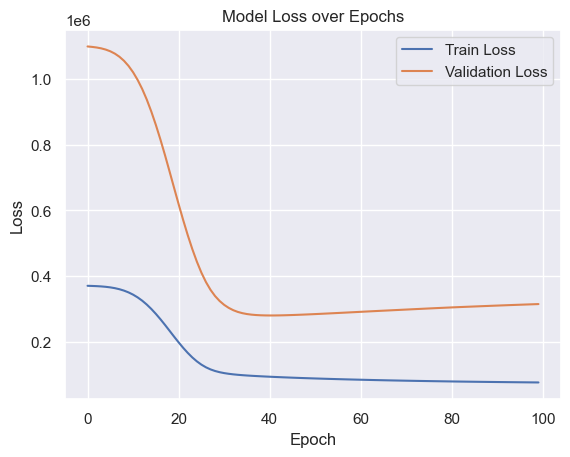

In [53]:
# Plot NN loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Remodel 2
## Base with carbon and tree loss

In [56]:
# Read data
df2 = pd.read_csv('/Users/achen1/MIDS-W207-DeforestationAndClimate/data/train_monthly.csv', sep='\t')
print(df2.columns)

Index(['Unnamed: 0', 'date', 'cdsd', 'cldd', 'dp01', 'dp10', 'dp1x', 'dsnd',
       'dsnw', 'dt00',
       ...
       'tc_loss_ha_Uruguay', 'tc_loss_ha_Uzbekistan', 'tc_loss_ha_Vanuatu',
       'tc_loss_ha_Venezuela', 'tc_loss_ha_Vietnam',
       'tc_loss_ha_Virgin Islands, U.S.', 'tc_loss_ha_Zambia',
       'tc_loss_ha_Zimbabwe', 'tc_loss_ha_Åland', 'tc_loss_ha_average'],
      dtype='object', length=1135)


In [57]:
# Create new df
print(df2[['date','dp10','emxp','snow','prcp','carbon_average','tc_loss_ha_average']].head(10))

df2_base = df2[['date','dp10','emxp','snow','prcp','carbon_average','tc_loss_ha_average']]
print(df2_base)

      date  dp10  emxp    snow   prcp  carbon_average  tc_loss_ha_average
0  2001-01   5.0  18.3   661.0   47.9    2.056476e+07        56587.483051
1  2001-02  10.0  27.9  1589.0  123.5    2.056476e+07        56587.483051
2  2001-03   6.0  13.5   178.0   39.8    2.056476e+07        56587.483051
3  2001-04   6.0  19.6   580.0   58.9    2.056476e+07        56587.483051
4  2001-05   1.0   6.1     0.0    6.1    2.056476e+07        56587.483051
5  2001-06   0.0   0.0     0.0    0.0    2.056476e+07        56587.483051
6  2001-07   0.0   0.0     0.0    0.0    2.056476e+07        56587.483051
7  2001-08   0.0   0.0     0.0    0.0    2.056476e+07        56587.483051
8  2001-09   1.0   8.9     0.0    8.9    2.056476e+07        56587.483051
9  2001-10   1.0  20.3     0.0   21.6    2.056476e+07        56587.483051
        date  dp10  emxp    snow   prcp  carbon_average  tc_loss_ha_average
0    2001-01   5.0  18.3   661.0   47.9    2.056476e+07        56587.483051
1    2001-02  10.0  27.9  1589.0  

In [65]:
# Create feature and outcome
tf.random.set_seed(1234)
np.random.seed(1234)

X = df2_base[['dp10','emxp','snow','prcp','carbon_average','tc_loss_ha_average']]  # Features
y = df2_base['snow']  # Target variable

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [66]:
# Simple model
tf.random.set_seed(1234)
np.random.seed(1234)

model = LinearRegression()
model.fit(X_train, y_train)

# Check MSE 
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Check coefficients
print('Model coefficients:', model.coef_)

Mean Squared Error: 3.4778946455549526e-23
Model coefficients: [ 7.37211922e-13 -2.52298616e-13  1.00000000e+00  8.79804658e-16
  1.01649658e-18 -3.68032390e-16]


## NN Base 2

In [67]:
# Base NN

tf.random.set_seed(1234)
np.random.seed(1234)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
# Base NN model

tf.random.set_seed(1234)
np.random.seed(1234)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1) 
])

model.compile(optimizer='adam',
              loss='mean_squared_error')

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=10, validation_split=0.1)


Epoch 1/100


/Users/achen1/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 302994.4062 - val_loss: 1098138.1250
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 302403.3125 - val_loss: 1095991.8750
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 301660.4375 - val_loss: 1093016.7500
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 300618.0625 - val_loss: 1088761.5000
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 299126.5000 - val_loss: 1082817.0000
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 297036.5000 - val_loss: 1074445.5000
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 294124.7188 - val_loss: 1062924.1250
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 290169.0312 - val_loss: 1047551.6875
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 284951.2812 - val_loss: 1027576.5000
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 278212.4062 - val_loss: 1002028.6250
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test MSE: 15792.576606970544


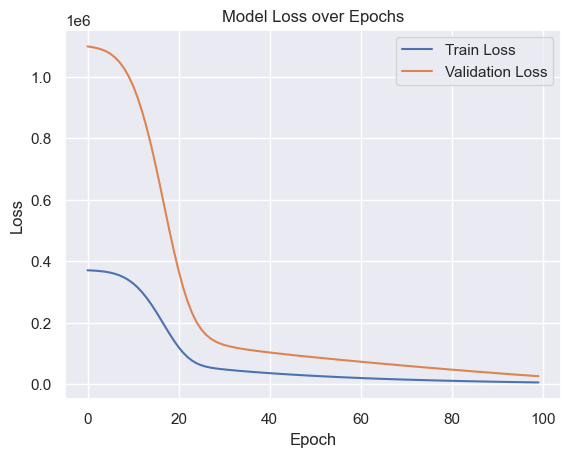

In [73]:
# Check MSE and plot loss

tf.random.set_seed(1234)
np.random.seed(1234)

y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print('Test MSE:', mse)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()